In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *

import ipywidgets as widgets

In [2]:
class azim_elev_analysis():
    def __init__(self):
        self.azim_slider = widgets.IntSlider(
            value=-90,
            min=-180,
            max=180,
            step=1,
            description='azim:',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

        elev_slider = widgets.IntSlider(
            value=0,
            min=-180,
            max=180,
            step=1,
            description='elev:',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

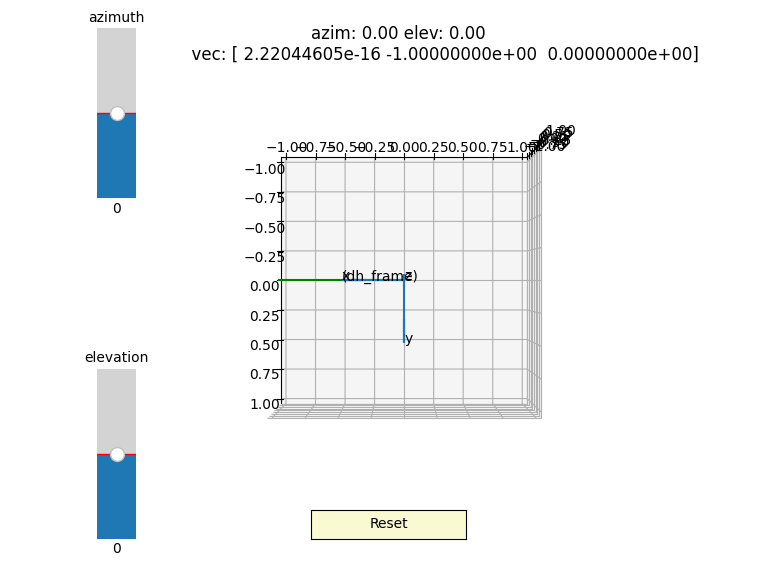

In [10]:
from matplotlib.widgets import Slider, Button

%matplotlib widget
fig = plt.figure(393)
fig.clear()
ax = axes_3d(fig, view=(90, 0))
set_xyzlim3d([-1, 1])
generate_world_frame().draw3d()

ax_azim = fig.add_axes([0.1, 0.65, 0.1, 0.3])
ax_elev = fig.add_axes([0.1, 0.05, 0.1, 0.3])
ax_reset = fig.add_axes([0.4, 0.05, 0.2, 0.05])

s_azim = Slider(ax = ax_azim, label = 'azimuth', valmin = -180, valmax = 180, valinit = 0, orientation="vertical")
s_elev = Slider(ax = ax_elev, label = 'elevation', valmin = -180, valmax = 180, valinit = 0, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

prev_azim = 0
prev_elev = 0
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
root_R = Rot_z_minus_90
root_tf = np.eye(4)
root_tf[:3, :3] = root_R
root_frame = generate_vis_frame([0,0,0], root_R)

def update(val):
    global prev_azim, prev_elev
    # update joint angles
    azim = s_azim.val
    elev = s_elev.val
    
    vec = azim_elev_to_vec(azim, elev, degrees=True) # wrt local frame
    vec = Rot_z_minus_90 @ vec # rotate the vector / expressed wrt world frame
    
    # update plot
    azim = ax.azim
    elev = ax.elev
    ax.cla()
    plt.sca(ax)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.view_init(elev, azim)
    #generate_world_frame().draw3d()
    root_frame.draw3d()
    ax.plot([0, vec[0]], [0, vec[1]], [0, vec[2]], 'g')
    azim_inv, elev_inv, azim_inv2, elev_inv2 = calculate_azimuth_elevation(vec, root_R=root_R, degrees=True, multi_sol=True)
    #ax.set_title(f"azim: {azim_inv:.2f} elev: {elev_inv:.2f}\n azim2: {azim_inv2:.2f} elev2: {elev_inv2:.2f}")
    tf1, dh_mat1 = build_dh_frame(azim_inv, elev_inv, 1, root_tf, degrees=True)
    tf2, dh_mat2 = build_dh_frame(azim_inv2, elev_inv2, 1, root_tf, degrees=True)
    R1 = tf1[:3, :3]
    R2 = tf2[:3, :3]
    q1 = Rotation.from_matrix(R1).as_quat()
    q2 = Rotation.from_matrix(R2).as_quat()

    if dist_between_points([azim_inv, elev_inv], [prev_azim, prev_elev]) > dist_between_points([azim_inv2, elev_inv2], [prev_azim, prev_elev]):
        azim_inv = azim_inv2
        elev_inv = elev_inv2
    if abs(elev_inv) == 90.0: azim_inv = prev_azim

    prev_azim = azim_inv
    prev_elev = elev_inv

    ax.set_title(f"azim: {azim_inv:.2f} elev: {elev_inv:.2f}\n \
                 vec: {vec}")    
s_azim.on_changed(update)
s_elev.on_changed(update)

def reset(event):
    s_azim.reset()
    s_elev.reset()

button.on_clicked(reset)

update(0)
plt.show()
